In [47]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_absolute_error, mean_squared_error
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from sklearn.preprocessing import MinMaxScaler

In [2]:
mer_df = pd.read_csv('mergedstocktweet.csv')

In [3]:
mer_df.head()

,ticker,date,adj_close,close,high,low,open,volume,prev_close_1,prev_close_2,prev_close_3,close_t_plus_1,close_t_plus_3,close_t_plus_7,daily_return,ma_5,sentiment
0,AMZN,08/01/2020,94.598503,94.598503,95.550003,94.321999,94.902000,70160000,95.343002,95.143997,93.748497,95.052498,94.565002,93.236000,-0.007809,94.746899,NaN
1,MSFT,19/05/2020,177.436157,183.630005,186.600006,183.490005,185.029999,26799100,184.910004,183.160004,180.529999,185.660004,183.509995,183.250000,-0.006922,182.396002,NaN
2,NVDA,09/04/2020,65.520805,65.737503,68.230003,65.105003,68.000000,52556400,66.737503,64.757500,67.099998,67.462502,70.209999,67.377502,-0.014984,65.062001,NaN
3,NVDA,20/11/2020,130.544632,130.877502,134.945007,130.649994,134.539993,34108800,134.402496,134.287506,134.222504,131.399994,132.347504,135.445007,-0.026227,133.788501,0.479733
4,AMZN,01/05/2020,114.302002,114.302002,118.122002,112.909500,116.839996,195452000,123.699997,118.635498,115.704002,115.799499,117.563003,117.847504,-0.075974,118.228301,0.074767


In [4]:
mer_df.shape

(1235, 17)

In [5]:
mer_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1235 entries, 0 to 1234
Data columns (total 17 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   ticker          1235 non-null   object 
 1   date            1235 non-null   object 
 2   adj_close       1235 non-null   float64
 3   close           1235 non-null   float64
 4   high            1235 non-null   float64
 5   low             1235 non-null   float64
 6   open            1235 non-null   float64
 7   volume          1235 non-null   int64  
 8   prev_close_1    1230 non-null   float64
 9   prev_close_2    1225 non-null   float64
 10  prev_close_3    1220 non-null   float64
 11  close_t_plus_1  1235 non-null   float64
 12  close_t_plus_3  1235 non-null   float64
 13  close_t_plus_7  1235 non-null   float64
 14  daily_return    1230 non-null   float64
 15  ma_5            1235 non-null   float64
 16  sentiment       820 non-null    float64
dtypes: float64(14), int64(1), object(

In [6]:
mer_df.describe()

,adj_close,close,high,low,open,volume,prev_close_1,prev_close_2,prev_close_3,close_t_plus_1,close_t_plus_3,close_t_plus_7,daily_return,ma_5,sentiment
count,1235.000000,1235.000000,1235.000000,1235.000000,1235.000000,1.235000e+03,1230.000000,1225.000000,1220.000000,1235.000000,1235.000000,1235.000000,1230.000000,1235.000000,820.000000
mean,120.352138,121.991374,123.929488,119.788716,121.886011,1.148069e+08,121.787216,121.574331,121.366054,122.357493,123.074900,124.557532,0.004209,121.263313,0.112107
std,48.751807,50.192909,50.656602,49.604321,50.210130,9.704000e+07,50.126686,50.040669,49.972292,50.216471,50.266860,50.443034,0.037125,50.014592,0.247491
min,24.081333,24.081333,26.990667,23.367332,24.980000,1.451220e+07,24.081333,24.081333,24.081333,24.081333,24.081333,24.081333,-0.210628,27.745067,-0.680800
25%,78.045811,79.778751,80.727501,78.983749,79.649998,4.242200e+07,79.729378,79.712502,79.656252,79.954998,80.519917,82.337502,-0.012154,79.251752,0.000000
50%,118.410858,119.209999,120.970001,117.155502,118.738998,8.693980e+07,119.040001,118.980499,118.720001,119.489998,120.511002,121.892502,0.003521,118.632402,0.094572
75%,157.215500,158.244995,160.097244,156.288750,158.651505,1.507010e+08,158.169746,158.128998,158.066246,158.387497,158.787750,159.431999,0.020653,157.822449,0.235805
max,231.666672,231.666672,232.860001,227.350006,229.270004,9.140820e+08,231.666672,231.649994,231.649994,231.666672,231.666672,235.223328,0.198949,227.988000,0.913600


In [7]:
mer_df.isnull().sum()

ticker              0
date                0
adj_close           0
close               0
high                0
low                 0
open                0
volume              0
prev_close_1        5
prev_close_2       10
prev_close_3       15
close_t_plus_1      0
close_t_plus_3      0
close_t_plus_7      0
daily_return        5
ma_5                0
sentiment         415
dtype: int64

In [8]:
mer_df['ticker'].value_counts()

ticker
AMZN    247
MSFT    247
NVDA    247
TSLA    247
AAPL    247
Name: count, dtype: int64

tweet_df = pd.read_csv('stocktweet.csv')
AAPL_df = pd.read_csv('AAPL.csv')
AMZN_df = pd.read_csv('AMZN.csv')
MSFT_df = pd.read_csv('MSFT.csv')
NVDA_df = pd.read_csv('NVDA.csv')
TSLA_df = pd.read_csv('TSLA.csv')

stock_dfs = {'AAPL': AAPL_df, 'AMZN': AMZN_df, 'MSFT': MSFT_df, 'NVDA': NVDA_df, 'TSLA': TSLA_df}

for ticker, df in stock_dfs.items():
    print(f"\n[{ticker}]")
    print(df.info())
    print(df.describe())
    print(df.head(3))

print(tweet_df.head(3))


for ticker, df in stock_dfs.items():
    print(f"\nMissing values in {ticker}:")
    print(df.isnull().sum())

print("\nMissing values in tweet_df:")
print(tweet_df.isnull().sum())


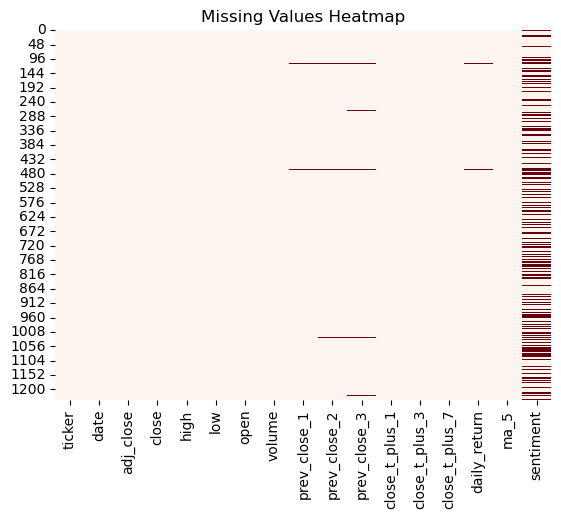

In [13]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.heatmap(mer_df.isnull(), cbar=False, cmap='Reds')
plt.title("Missing Values Heatmap")
plt.show()


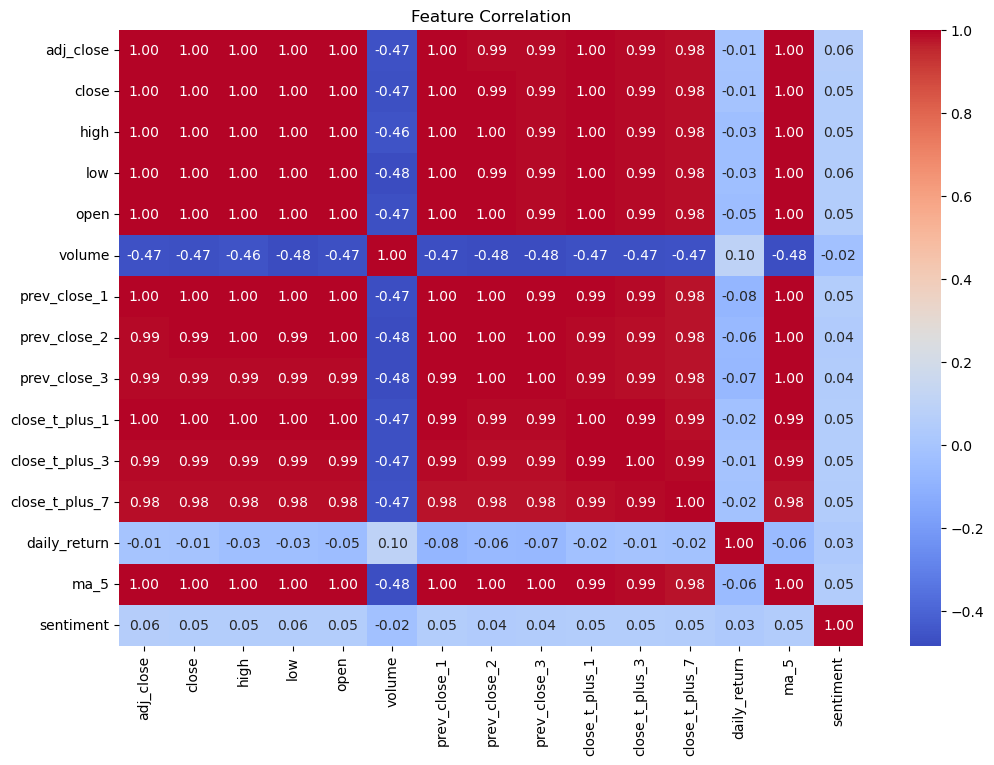

In [14]:
corr = mer_df.select_dtypes(include=['float64', 'int64']).corr()
plt.figure(figsize=(12, 8))
sns.heatmap(corr, annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Feature Correlation")
plt.show()

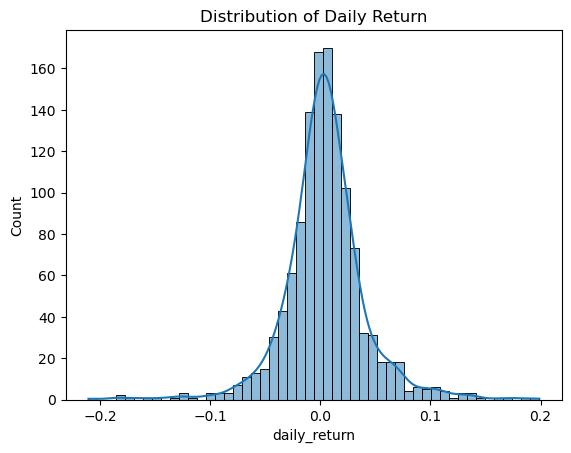

In [15]:
sns.histplot(mer_df['daily_return'].dropna(), bins=50, kde=True)
plt.title("Distribution of Daily Return")
plt.show()

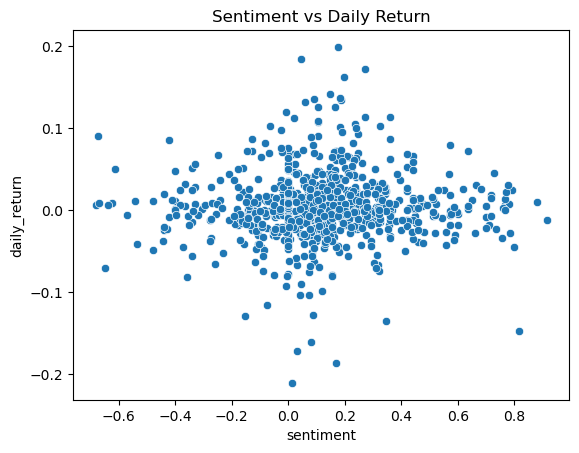

In [16]:
sns.scatterplot(data=mer_df, x='sentiment', y='daily_return')
plt.title("Sentiment vs Daily Return")
plt.show()

In [17]:
mer_df['date'] = pd.to_datetime(mer_df['date'], dayfirst=True)

In [18]:
mer_df = mer_df.sort_values(by=['ticker', 'date'])

In [19]:
mer_df = mer_df.dropna(subset=['close'])

In [20]:
print(f"Missing sentiment values: {mer_df['sentiment'].isna().sum()} out of {len(mer_df)}")

Missing sentiment values: 415 out of 1235


In [21]:
mer_df['sentiment'] = mer_df['sentiment'].fillna(0)

In [22]:
print(f"Missing sentiment after imputation: {mer_df['sentiment'].isna().sum()}")

Missing sentiment after imputation: 0


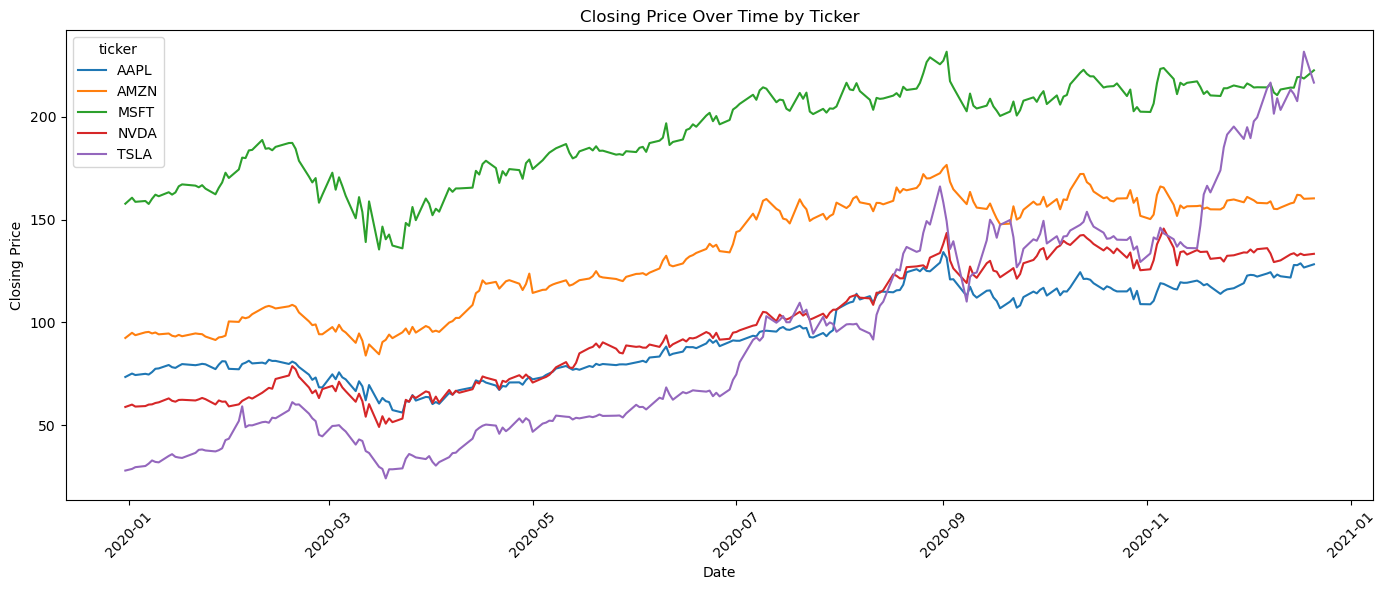

In [23]:
plt.figure(figsize=(14, 6))
sns.lineplot(data=mer_df, x='date', y='close', hue='ticker')
plt.title('Closing Price Over Time by Ticker')
plt.xlabel('Date')
plt.ylabel('Closing Price')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

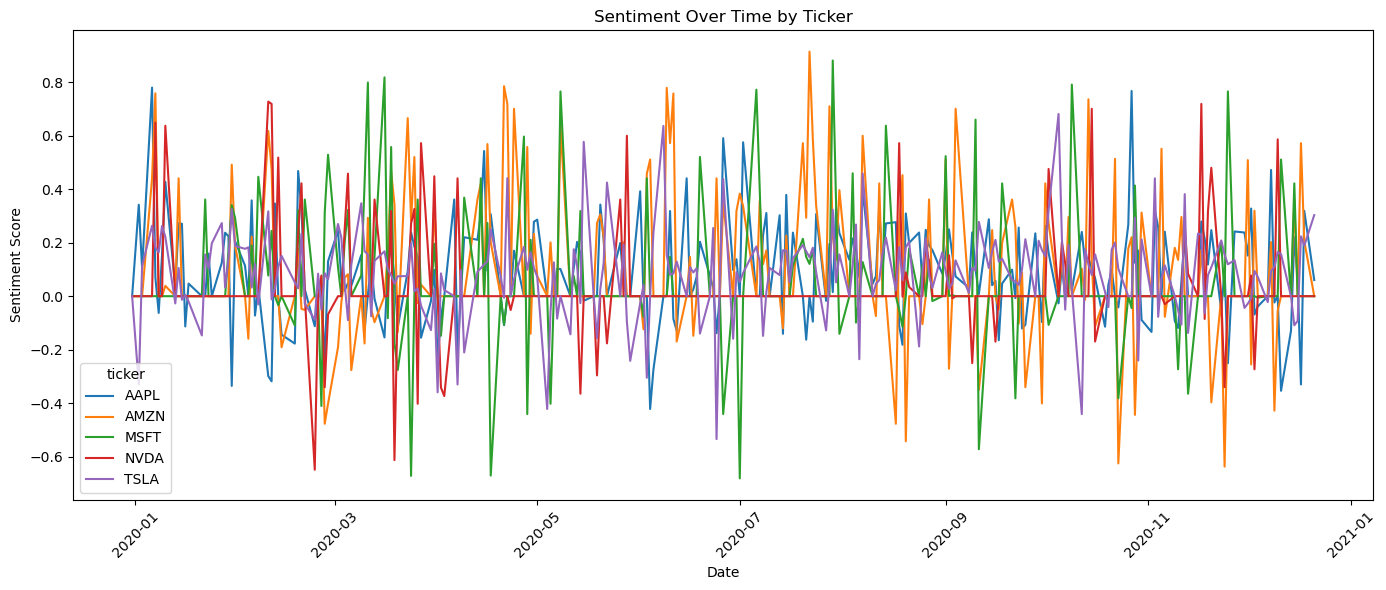

In [24]:
plt.figure(figsize=(14, 6))
sns.lineplot(data=mer_df, x='date', y='sentiment', hue='ticker')
plt.title('Sentiment Over Time by Ticker')
plt.xlabel('Date')
plt.ylabel('Sentiment Score')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

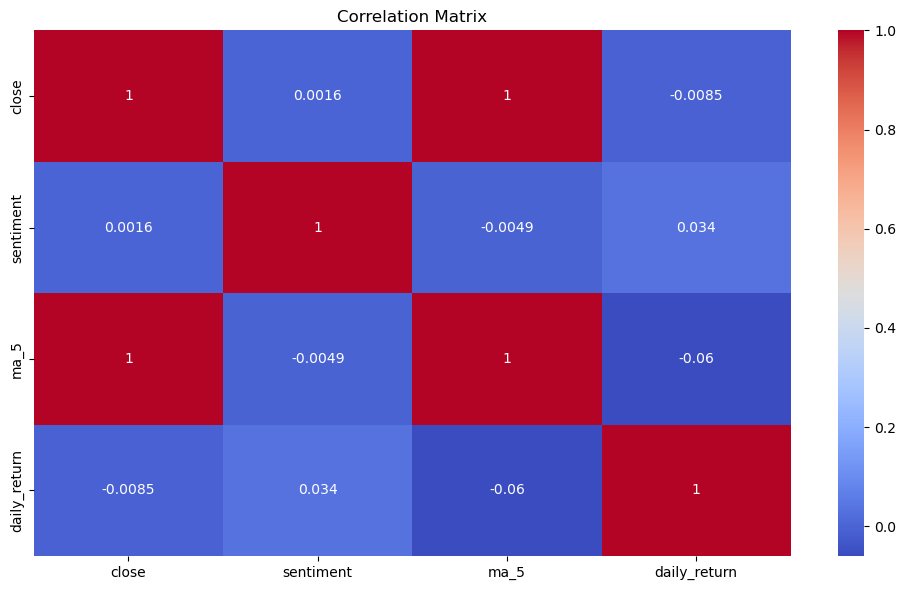

In [25]:
plt.figure(figsize=(10, 6))
corr_matrix = mer_df[['close', 'sentiment', 'ma_5', 'daily_return']].corr()
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm')
plt.title('Correlation Matrix')
plt.tight_layout()
plt.show()


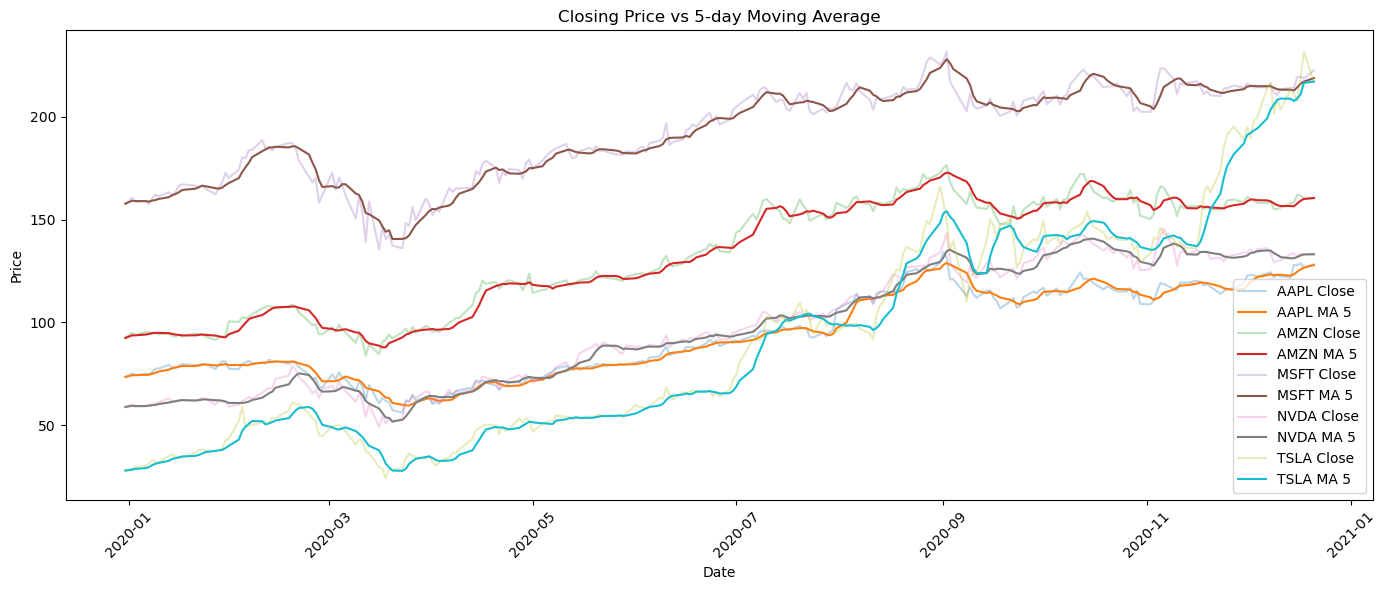

In [26]:
plt.figure(figsize=(14, 6))
for ticker in mer_df['ticker'].unique():
    ticker_df = mer_df[mer_df['ticker'] == ticker]
    plt.plot(ticker_df['date'], ticker_df['close'], label=f'{ticker} Close', alpha=0.3)
    plt.plot(ticker_df['date'], ticker_df['ma_5'], label=f'{ticker} MA 5')
plt.legend()
plt.title('Closing Price vs 5-day Moving Average')
plt.xlabel('Date')
plt.ylabel('Price')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

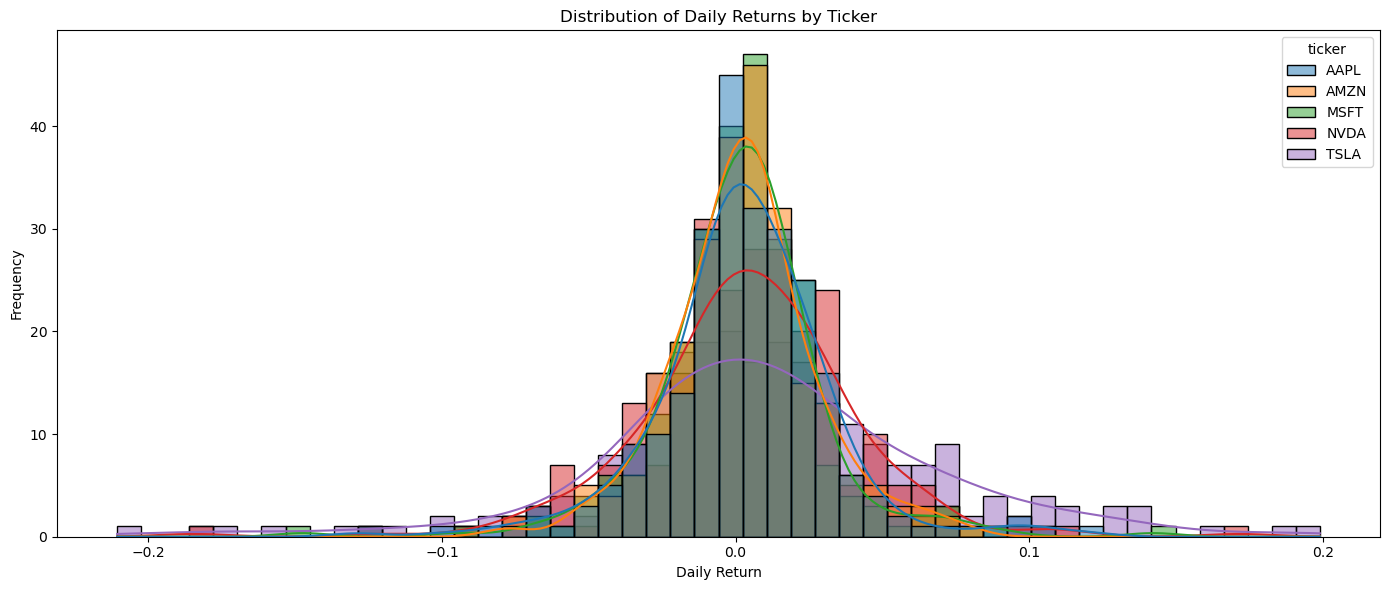

In [27]:
plt.figure(figsize=(14, 6))
sns.histplot(data=mer_df, x='daily_return', hue='ticker', kde=True, bins=50)
plt.title('Distribution of Daily Returns by Ticker')
plt.xlabel('Daily Return')
plt.ylabel('Frequency')
plt.tight_layout()
plt.show()

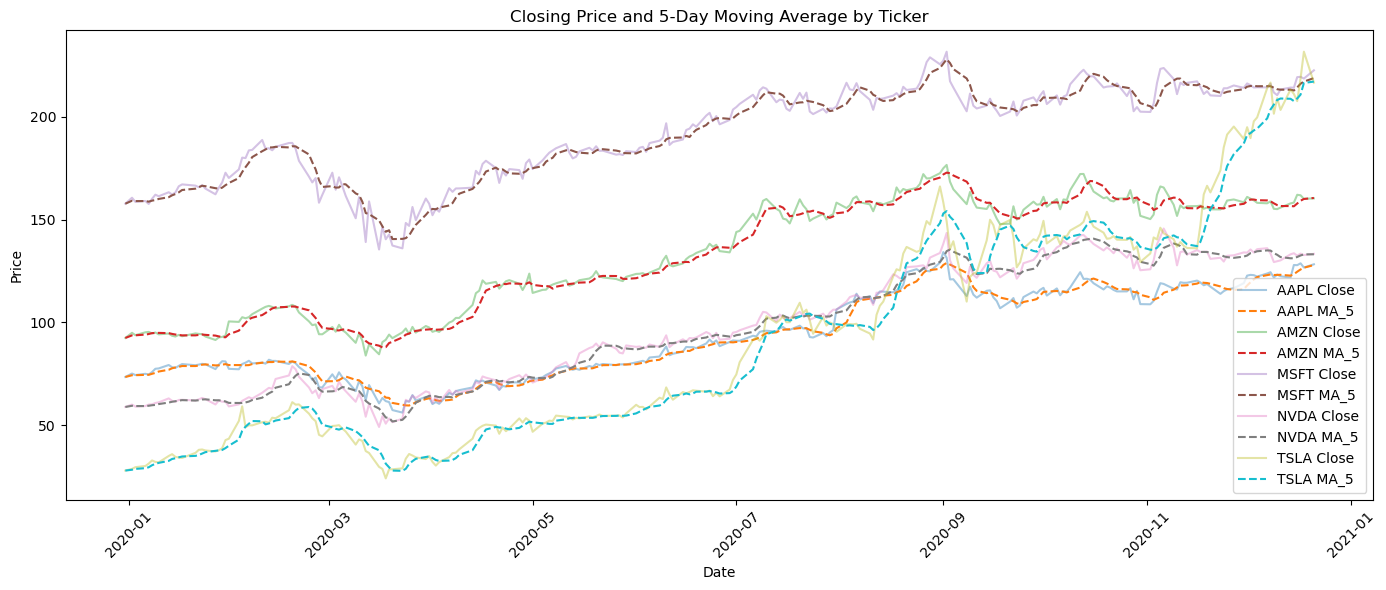

In [28]:
plt.figure(figsize=(14, 6))
for ticker in mer_df['ticker'].unique():
    df = mer_df[mer_df['ticker'] == ticker]
    plt.plot(df['date'], df['close'], label=f'{ticker} Close', alpha=0.4)
    plt.plot(df['date'], df['ma_5'], label=f'{ticker} MA_5', linestyle='--')
plt.title('Closing Price and 5-Day Moving Average by Ticker')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

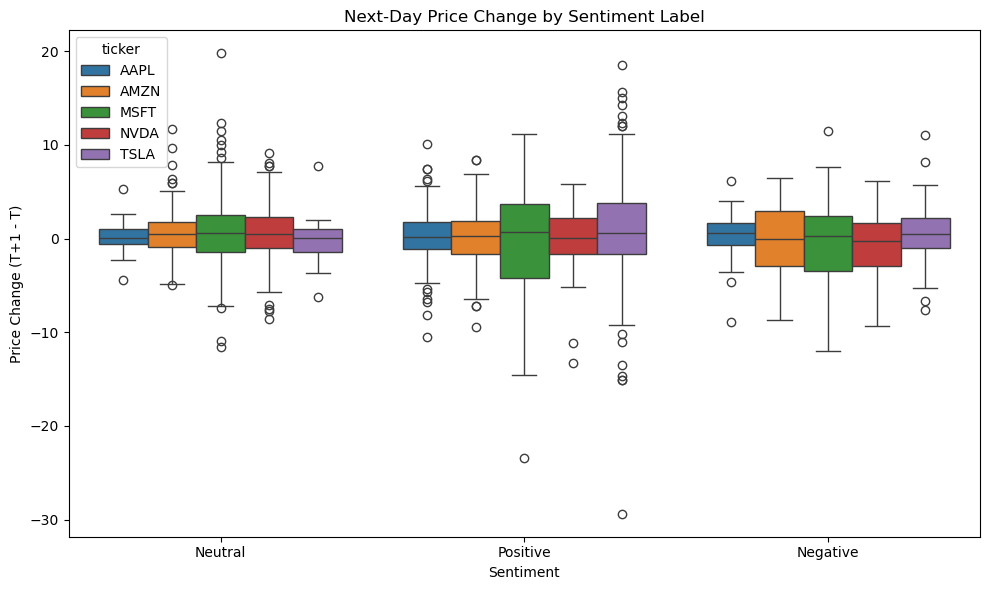

In [29]:
mer_df['next_day_return'] = mer_df['close_t_plus_1'] - mer_df['close']
mer_df['sentiment_label'] = mer_df['sentiment'].apply(lambda x: 'Positive' if x > 0 else ('Negative' if x < 0 else 'Neutral'))

plt.figure(figsize=(10, 6))
sns.boxplot(data=mer_df, x='sentiment_label', y='next_day_return', hue='ticker')
plt.title('Next-Day Price Change by Sentiment Label')
plt.xlabel('Sentiment')
plt.ylabel('Price Change (T+1 - T)')
plt.tight_layout()
plt.show()

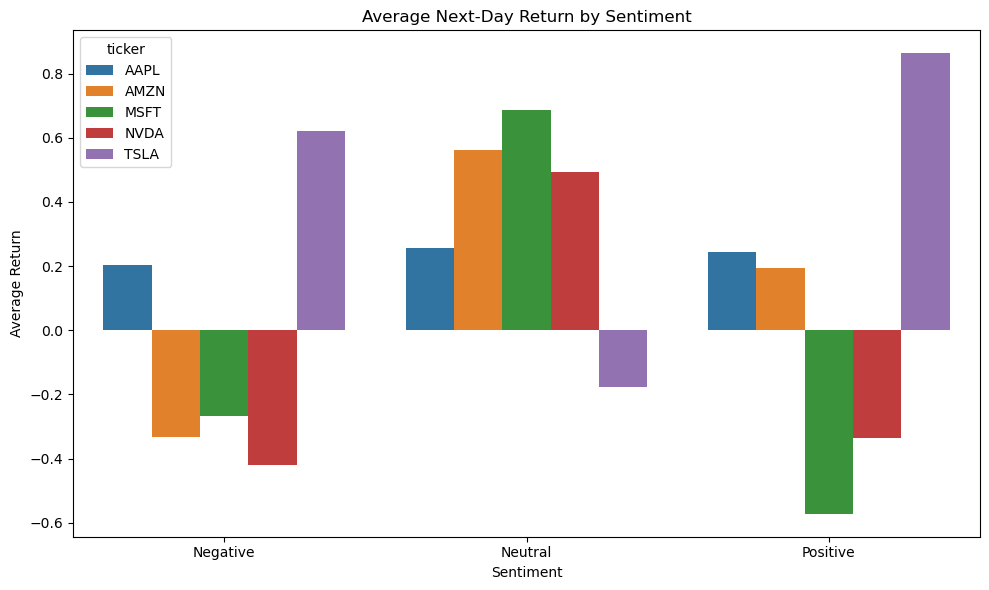

In [30]:
avg_return = mer_df.groupby(['ticker', 'sentiment_label'])['next_day_return'].mean().reset_index()

plt.figure(figsize=(10, 6))
sns.barplot(data=avg_return, x='sentiment_label', y='next_day_return', hue='ticker')
plt.title('Average Next-Day Return by Sentiment')
plt.xlabel('Sentiment')
plt.ylabel('Average Return')
plt.tight_layout()
plt.show()

In [31]:
mer_df.shape

(1235, 19)

In [32]:
mer_df = mer_df.dropna(subset=['prev_close_1', 'prev_close_2', 'prev_close_3', 'daily_return'])

In [33]:
print(f"New shape after dropping missing rows: {mer_df.shape}")

New shape after dropping missing rows: (1220, 19)


In [35]:
mer_df['date'] = pd.to_datetime(mer_df['date'], dayfirst=True)
mer_df = mer_df.sort_values('date')

In [37]:
all_results = []

for ticker in mer_df['ticker'].unique():
    print(f"\nProcessing ticker: {ticker}")
    
    df = mer_df[mer_df['ticker'] == ticker].copy()
    df = df.dropna(subset=['adj_close', 'sentiment', 'close_t_plus_1', 'close_t_plus_3', 'close_t_plus_7'])
    df.set_index('date', inplace=True)
    
    y = df['adj_close']
    
    try:
        model = ARIMA(y, order=(5, 1, 0))  # ARIMA(5,1,0) as baseline
        model_fit = model.fit()
    except:
        print(f"Skipping {ticker} due to fitting error.")
        continue


Processing ticker: AAPL

Processing ticker: MSFT

Processing ticker: NVDA


C:\Users\alame\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\alame\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\alame\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\alame\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(d


Processing ticker: AMZN

Processing ticker: TSLA


C:\Users\alame\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\alame\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\alame\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\alame\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(d


Processing ticker: AAPL


C:\Users\alame\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\alame\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\alame\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\alame\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\U

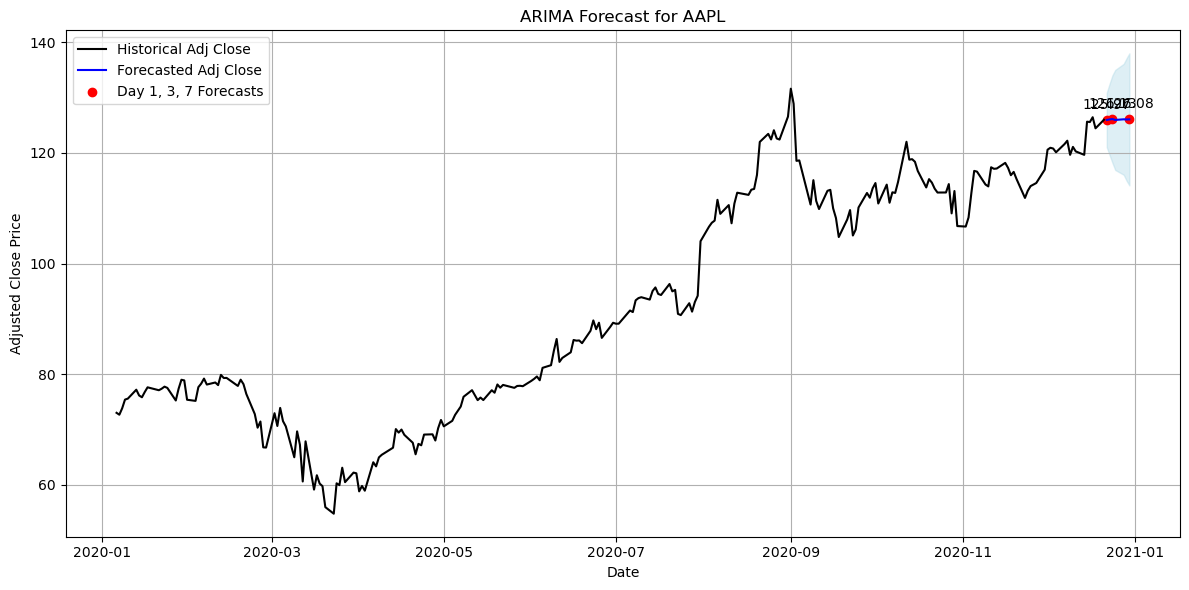


Processing ticker: MSFT


C:\Users\alame\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\alame\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\alame\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\alame\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\U

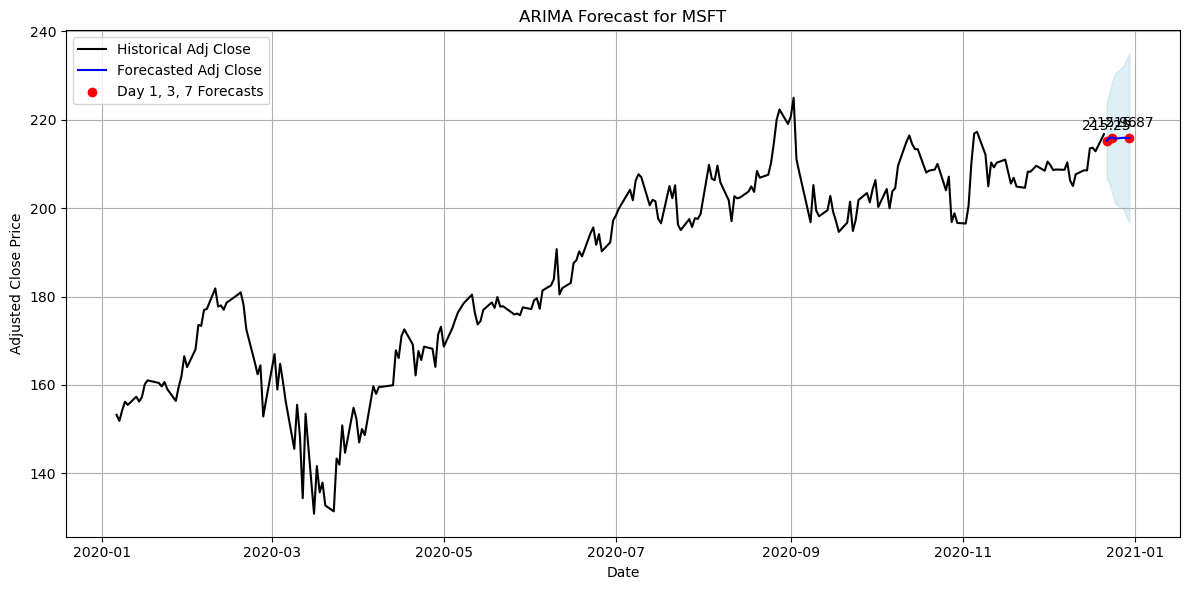


Processing ticker: NVDA


C:\Users\alame\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\alame\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\alame\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\alame\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\U

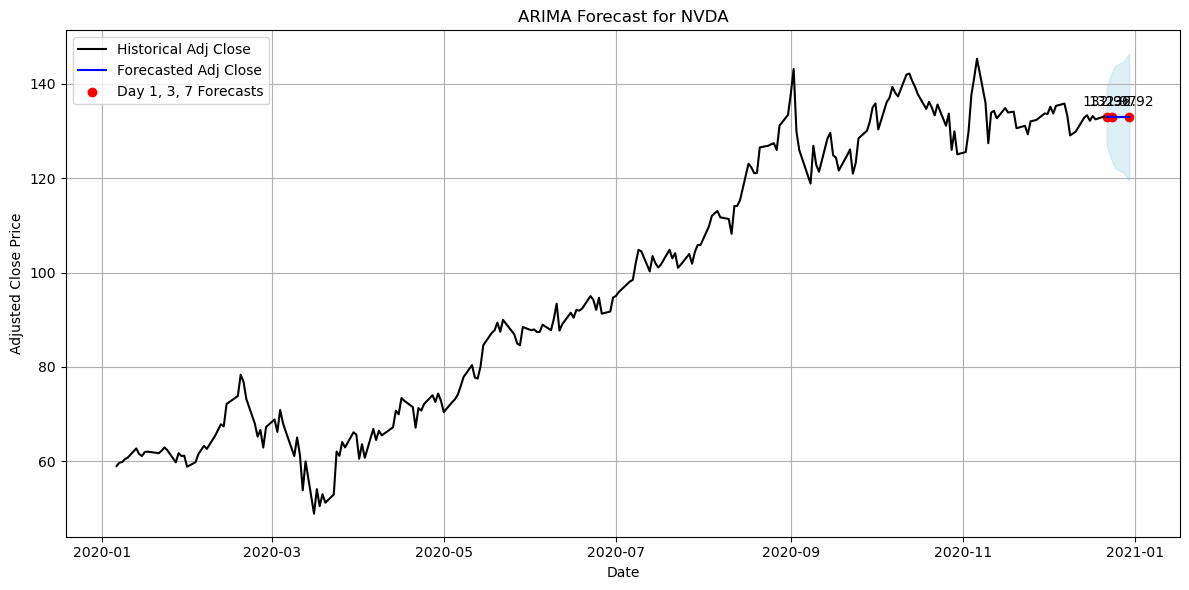


Processing ticker: AMZN


C:\Users\alame\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\alame\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\alame\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\alame\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\U

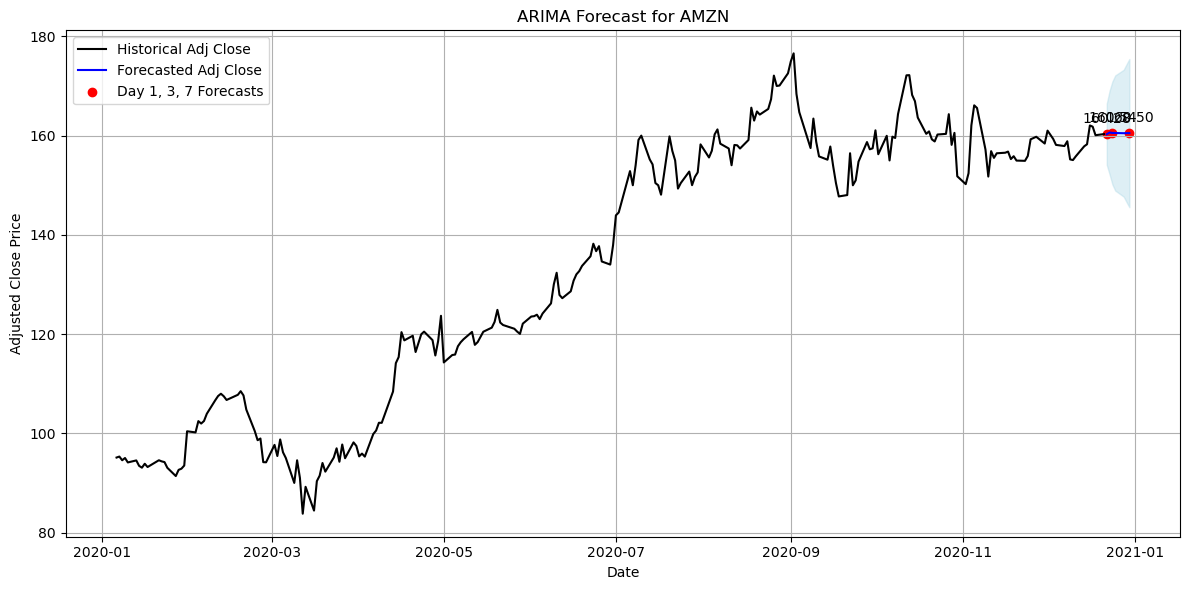


Processing ticker: TSLA


C:\Users\alame\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\alame\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\alame\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\alame\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\U

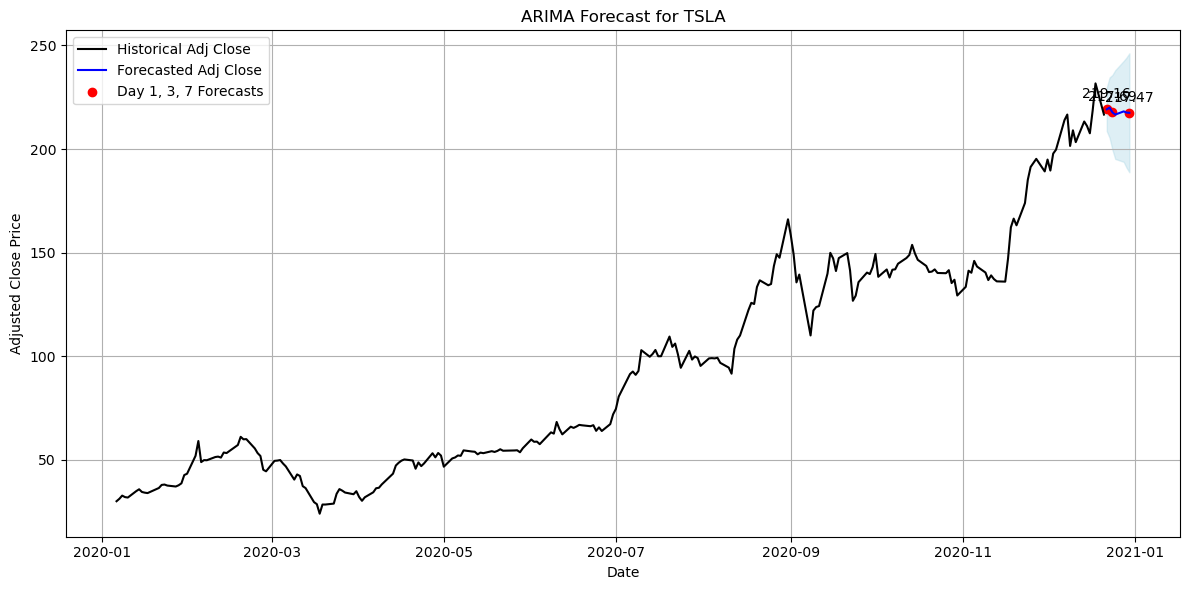


Model Performance Summary:
  Ticker  Day 1 Forecast  Actual Day 1  Day 3 Forecast  Actual Day 3  \
0   AAPL      125.970318    131.880005      126.131467    131.970001   
1   MSFT      215.253964    223.940002      215.958971    222.750000   
2   NVDA      132.960315    132.782501      132.966242    129.937500   
3   AMZN      160.284527    160.326004      160.538418    158.634506   
4   TSLA      219.160602    213.446671      217.694020    220.589996   

   Day 7 Forecast  Actual Day 7       MAE       RMSE  
0      126.076805    132.690002  6.120473   6.130450  
1      215.865981    222.419998  7.343695   7.405414  
2      132.920687    130.550003  1.859080   2.222989  
3      160.504191    162.846497  1.429231   1.742890  
4      217.469715    235.223328  8.787840  10.896887  


In [41]:
mer_df['date'] = pd.to_datetime(mer_df['date'], dayfirst=True)
mer_df = mer_df.sort_values('date')

all_results = []

for ticker in mer_df['ticker'].unique():
    print(f"\nProcessing ticker: {ticker}")
    
    df = mer_df[mer_df['ticker'] == ticker].copy()
    df = df.dropna(subset=['adj_close', 'sentiment', 'close_t_plus_1', 'close_t_plus_3', 'close_t_plus_7'])
    df.set_index('date', inplace=True)
    
    y = df['adj_close']
    
    try:
        model = ARIMA(y, order=(5, 1, 0))  # ARIMA(5,1,0) as baseline
        model_fit = model.fit()
    except:
        print(f"Skipping {ticker} due to fitting error.")
        continue

    forecast_steps = 7
    forecast = model_fit.get_forecast(steps=forecast_steps)
    forecast_index = pd.date_range(start=y.index[-1] + pd.Timedelta(days=1), periods=forecast_steps, freq='B')
    forecast_mean = forecast.predicted_mean
    conf_int = forecast.conf_int()

    forecasted = {
        'Day 1 Forecast': forecast_mean.iloc[0],
        'Day 3 Forecast': forecast_mean.iloc[2],
        'Day 7 Forecast': forecast_mean.iloc[6],
        'Actual Day 1': df['close_t_plus_1'].iloc[-1],
        'Actual Day 3': df['close_t_plus_3'].iloc[-1],
        'Actual Day 7': df['close_t_plus_7'].iloc[-1],
    }

    mae = mean_absolute_error(
        [forecasted['Actual Day 1'], forecasted['Actual Day 3'], forecasted['Actual Day 7']],
        [forecasted['Day 1 Forecast'], forecasted['Day 3 Forecast'], forecasted['Day 7 Forecast']]
    )
    rmse = np.sqrt(mean_squared_error(
        [forecasted['Actual Day 1'], forecasted['Actual Day 3'], forecasted['Actual Day 7']],
        [forecasted['Day 1 Forecast'], forecasted['Day 3 Forecast'], forecasted['Day 7 Forecast']]
    ))

    forecasted.update({'MAE': mae, 'RMSE': rmse, 'Ticker': ticker})
    all_results.append(forecasted)

    plt.figure(figsize=(12, 6))
    plt.plot(y, label='Historical Adj Close', color='black')
    plt.plot(forecast_index, forecast_mean, label='Forecasted Adj Close', color='blue')
    plt.fill_between(forecast_index, conf_int.iloc[:, 0], conf_int.iloc[:, 1], color='lightblue', alpha=0.4)

    
    highlight_days = [0, 2, 6]
    highlight_dates = forecast_index[highlight_days]
    highlight_values = forecast_mean.iloc[highlight_days]
    plt.scatter(highlight_dates, highlight_values, color='red', label='Day 1, 3, 7 Forecasts')

    for i, (x, y_val) in enumerate(zip(highlight_dates, highlight_values)):
        plt.annotate(f"{y_val:.2f}", (x, y_val), textcoords="offset points", xytext=(0, 8), ha='center')

    plt.title(f'ARIMA Forecast for {ticker}')
    plt.xlabel('Date')
    plt.ylabel('Adjusted Close Price')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

results_df = pd.DataFrame(all_results)
print("\nModel Performance Summary:")
print(results_df[['Ticker', 'Day 1 Forecast', 'Actual Day 1', 'Day 3 Forecast', 'Actual Day 3',
                  'Day 7 Forecast', 'Actual Day 7', 'MAE', 'RMSE']])



Processing ticker: AAPL


C:\Users\alame\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\alame\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\alame\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\alame\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\U

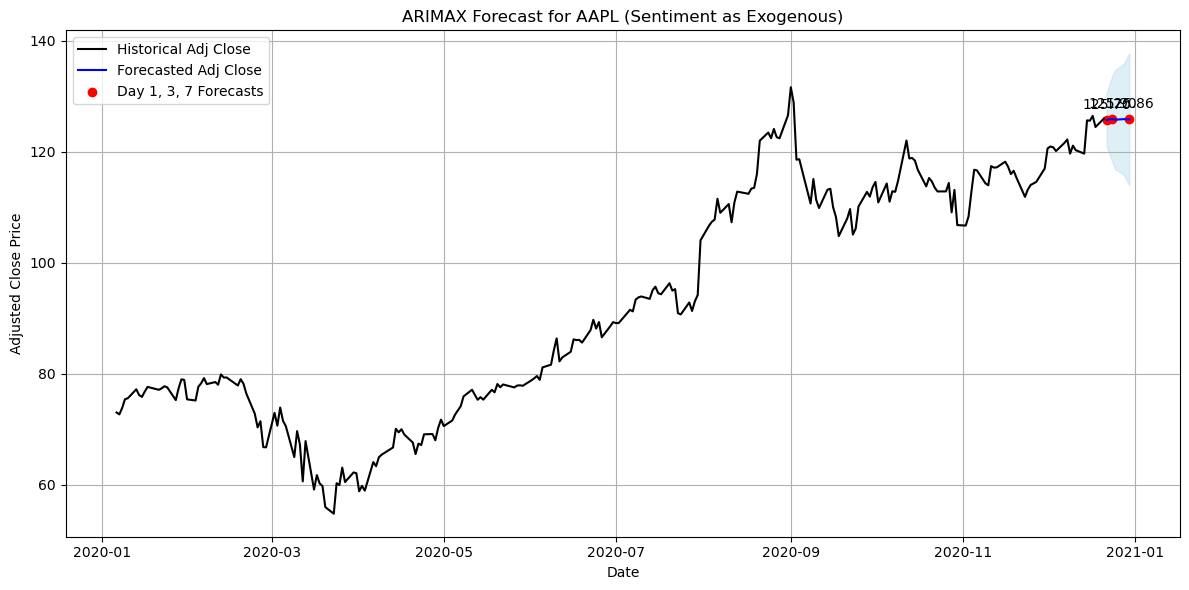


Processing ticker: AMZN


C:\Users\alame\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\alame\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\alame\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\alame\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\U

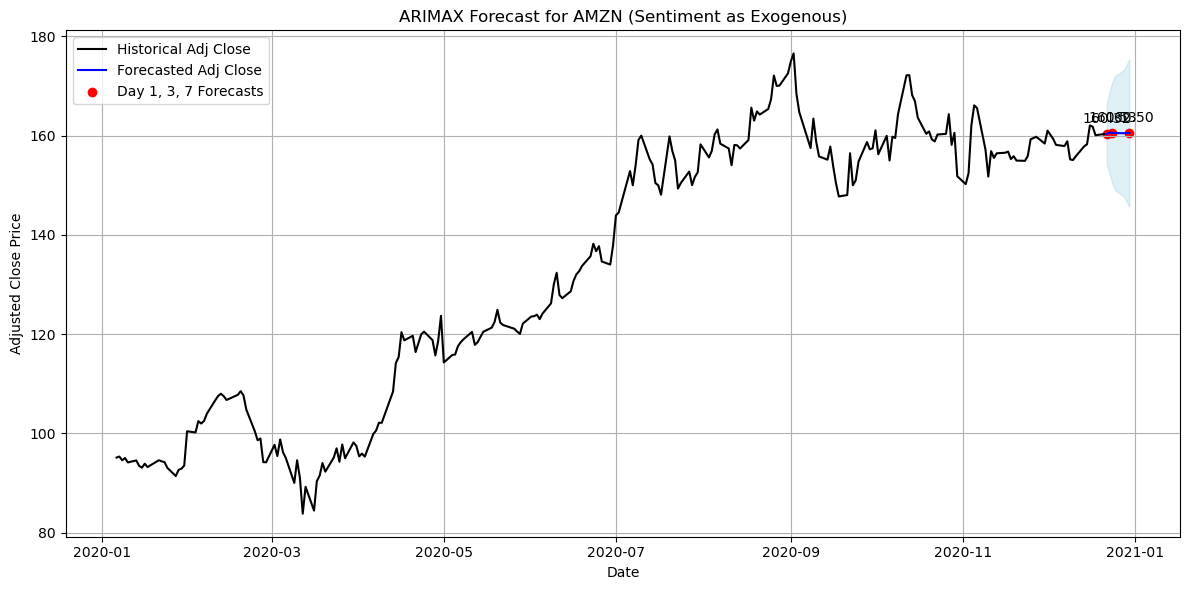


Processing ticker: MSFT


C:\Users\alame\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\alame\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\alame\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\alame\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\U

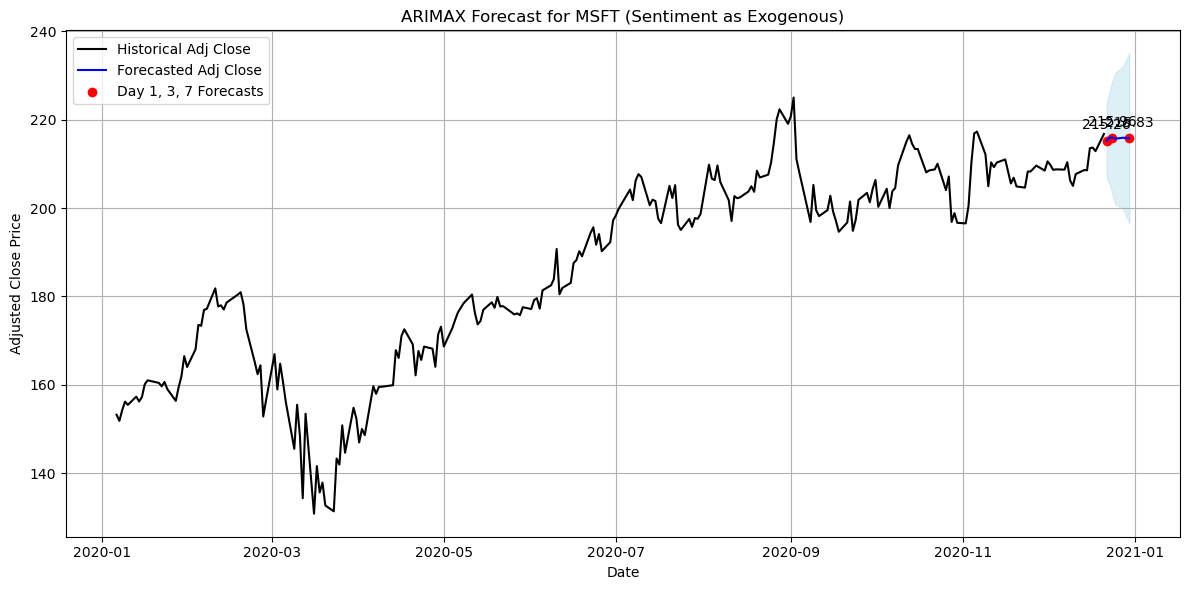


Processing ticker: NVDA


C:\Users\alame\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\alame\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\alame\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\alame\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\U

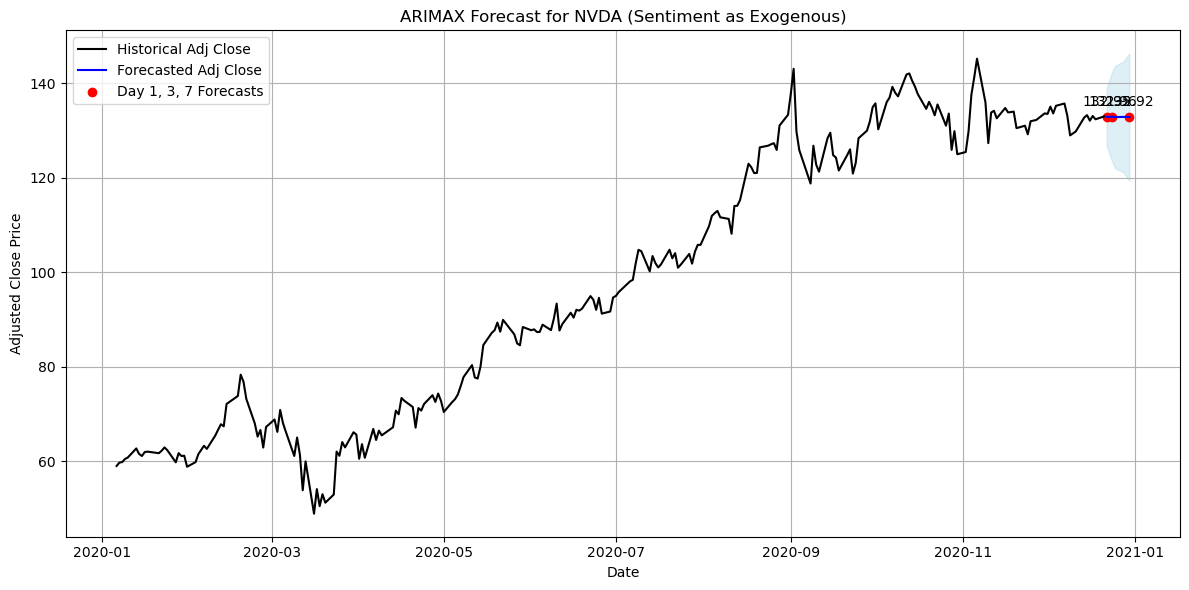


Processing ticker: TSLA


C:\Users\alame\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\alame\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\alame\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\alame\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\U

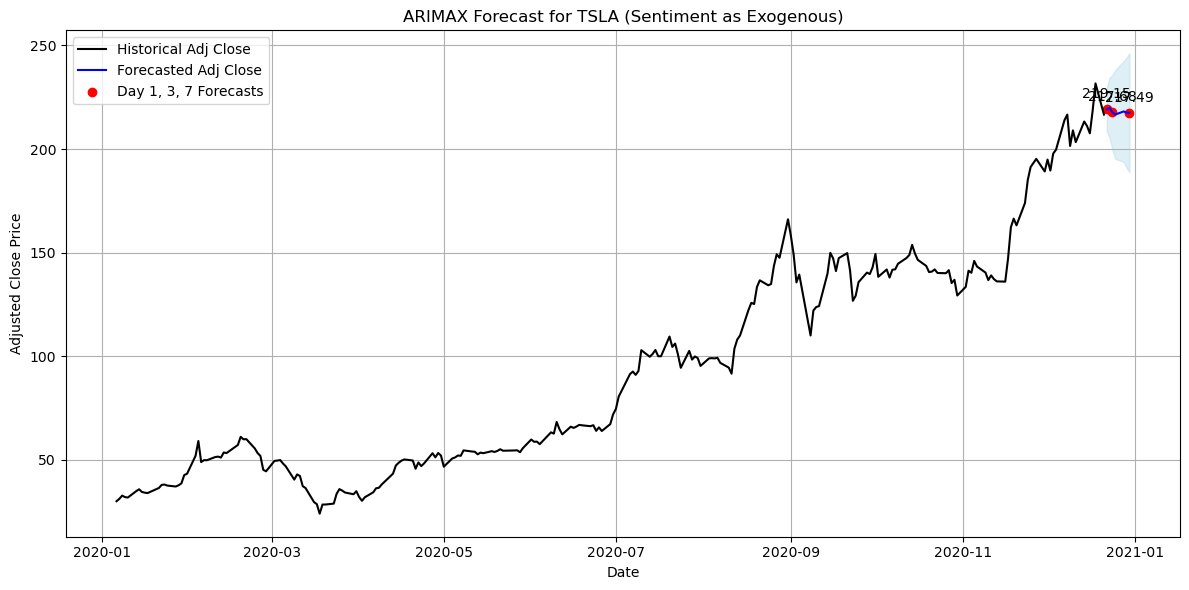


Model Performance Summary:
  Ticker  Day 1 Forecast  Actual Day 1  Day 3 Forecast  Actual Day 3  \
0   AAPL      125.704918    131.880005      125.902922    131.970001   
1   AMZN      160.316389    160.326004      160.528830    158.634506   
2   MSFT      215.263285    223.940002      215.955356    222.750000   
3   NVDA      132.953632    132.782501      132.964365    129.937500   
4   TSLA      219.146438    213.446671      217.682185    220.589996   

   Day 7 Forecast  Actual Day 7       MAE       RMSE  
0      125.861691    132.690002  6.356826   6.365715  
1      160.504340    162.846497  1.415365   1.739181  
2      215.825873    222.419998  7.355162   7.414740  
3      132.916498    130.550003  1.854830   2.220473  
4      217.485207    235.223328  8.781900  10.887051  


In [45]:
mer_df['date'] = pd.to_datetime(mer_df['date'], dayfirst=True)
mer_df = mer_df.sort_values(['ticker', 'date'])

all_results = []

for ticker in mer_df['ticker'].unique():
    print(f"\nProcessing ticker: {ticker}")
    
    df = mer_df[mer_df['ticker'] == ticker].copy()
    
    
    df = df.dropna(subset=['adj_close', 'sentiment', 'close_t_plus_1', 'close_t_plus_3', 'close_t_plus_7'])
    df.set_index('date', inplace=True)

    
    y = df['adj_close']
    exog = df[['sentiment']]

    try:
        model = ARIMA(y, exog=exog, order=(5, 1, 0))
        model_fit = model.fit()
    except Exception as e:
        print(f"Skipping {ticker} due to model fitting error: {e}")
        continue

    last_sentiment = exog.iloc[-1].values[0]
    future_exog = pd.DataFrame({'sentiment': [last_sentiment] * 7})

    forecast = model_fit.get_forecast(steps=7, exog=future_exog)
    forecast_index = pd.date_range(start=y.index[-1] + pd.Timedelta(days=1), periods=7, freq='B')
    forecast_mean = forecast.predicted_mean
    conf_int = forecast.conf_int()

    forecasted = {
        'Day 1 Forecast': forecast_mean.iloc[0],
        'Day 3 Forecast': forecast_mean.iloc[2],
        'Day 7 Forecast': forecast_mean.iloc[6],
        'Actual Day 1': df['close_t_plus_1'].iloc[-1],
        'Actual Day 3': df['close_t_plus_3'].iloc[-1],
        'Actual Day 7': df['close_t_plus_7'].iloc[-1],
    }

    mae = mean_absolute_error(
        [forecasted['Actual Day 1'], forecasted['Actual Day 3'], forecasted['Actual Day 7']],
        [forecasted['Day 1 Forecast'], forecasted['Day 3 Forecast'], forecasted['Day 7 Forecast']]
    )
    rmse = np.sqrt(mean_squared_error(
        [forecasted['Actual Day 1'], forecasted['Actual Day 3'], forecasted['Actual Day 7']],
        [forecasted['Day 1 Forecast'], forecasted['Day 3 Forecast'], forecasted['Day 7 Forecast']]
    ))

    forecasted.update({'MAE': mae, 'RMSE': rmse, 'Ticker': ticker})
    all_results.append(forecasted)

    plt.figure(figsize=(12, 6))
    plt.plot(y, label='Historical Adj Close', color='black')
    plt.plot(forecast_index, forecast_mean, label='Forecasted Adj Close', color='blue')
    plt.fill_between(forecast_index, conf_int.iloc[:, 0], conf_int.iloc[:, 1], color='lightblue', alpha=0.4)

    highlight_days = [0, 2, 6]
    highlight_dates = forecast_index[highlight_days]
    highlight_values = forecast_mean.iloc[highlight_days]
    plt.scatter(highlight_dates, highlight_values, color='red', label='Day 1, 3, 7 Forecasts')

    for i, (x, y_val) in enumerate(zip(highlight_dates, highlight_values)):
        plt.annotate(f"{y_val:.2f}", (x, y_val), textcoords="offset points", xytext=(0, 8), ha='center')

    plt.title(f'ARIMAX Forecast for {ticker} (Sentiment as Exogenous)')
    plt.xlabel('Date')
    plt.ylabel('Adjusted Close Price')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

results_df = pd.DataFrame(all_results)
print("\nModel Performance Summary:")
print(results_df[['Ticker', 'Day 1 Forecast', 'Actual Day 1', 'Day 3 Forecast', 'Actual Day 3',
                  'Day 7 Forecast', 'Actual Day 7', 'MAE', 'RMSE']])



Processing ticker: AAPL


C:\Users\alame\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 254ms/step


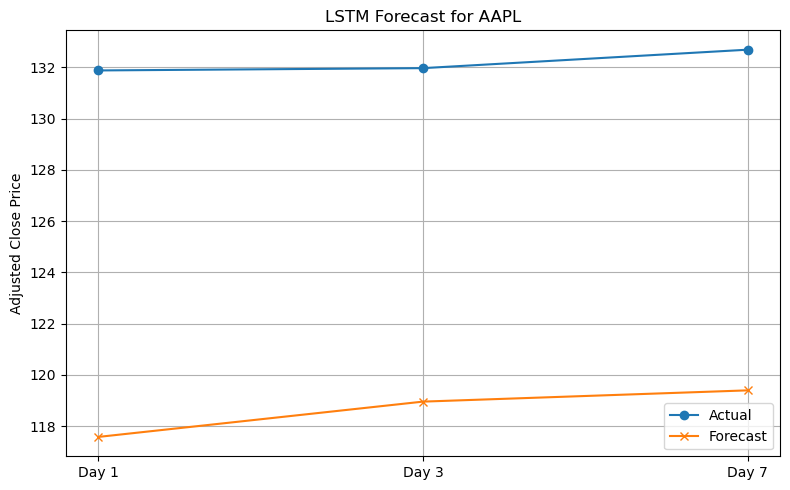


Processing ticker: AMZN


C:\Users\alame\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 312ms/step


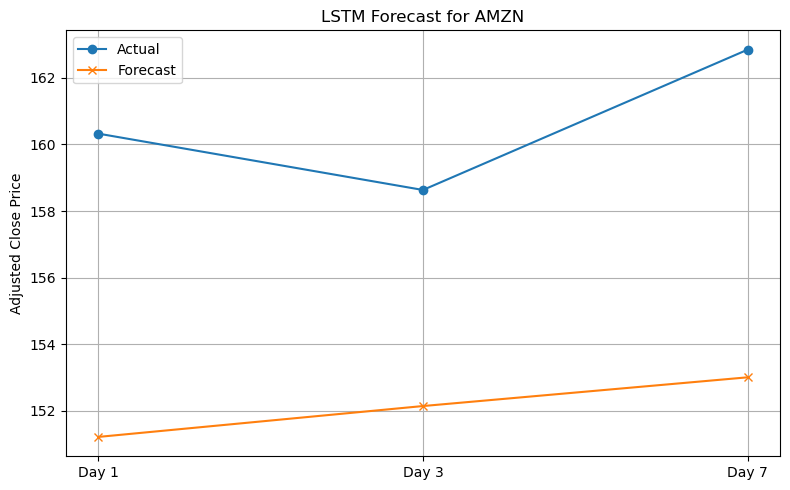


Processing ticker: MSFT


C:\Users\alame\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 259ms/step


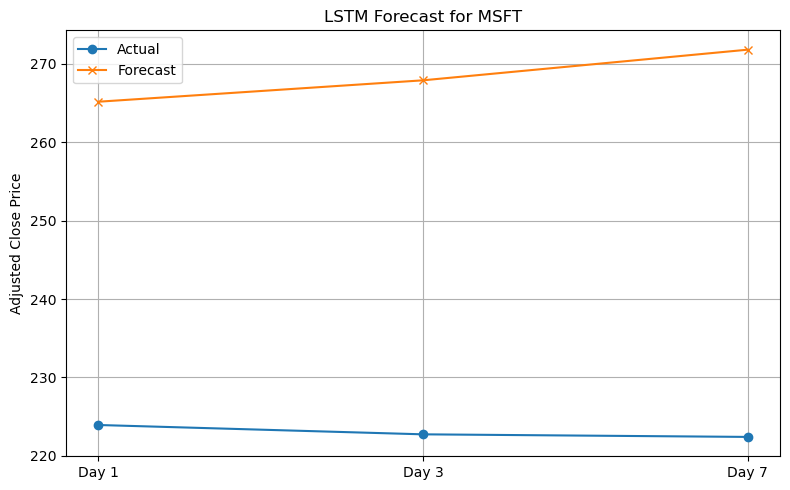


Processing ticker: NVDA


C:\Users\alame\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 289ms/step


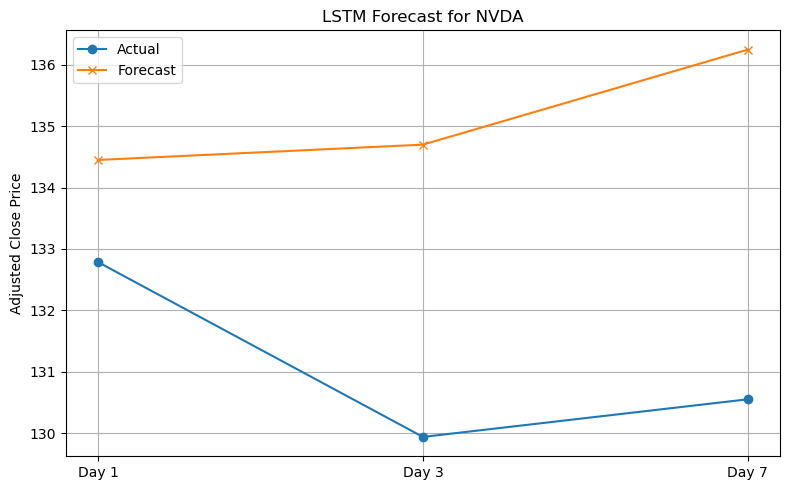


Processing ticker: TSLA


C:\Users\alame\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 303ms/step


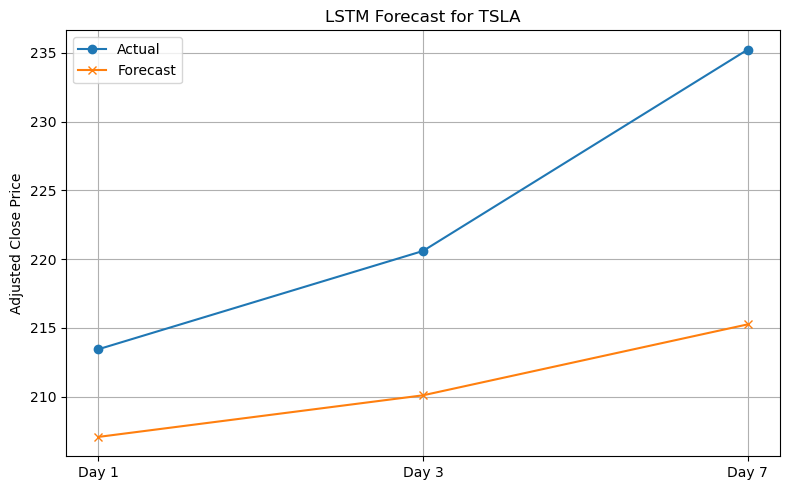


LSTM Model Performance Summary:
  Ticker  Day 1 Forecast  Actual Day 1  Day 3 Forecast  Actual Day 3  \
0   AAPL      117.576637    131.880005      118.954163    131.970001   
1   AMZN      151.219467    160.326004      152.146469    158.634506   
2   MSFT      265.165161    223.940002      267.894440    222.750000   
3   NVDA      134.449783    132.782501      134.699493    129.937500   
4   TSLA      207.073441    213.446671      210.097504    220.589996   

   Day 7 Forecast  Actual Day 7        MAE       RMSE  
0      119.393532    132.690002  13.538559  13.549840  
1      153.008987    162.846497   8.477361   8.598454  
2      271.800049    222.419998  45.249882  45.372253  
3      136.246216    130.550003   4.041830   4.393300  
4      215.252182    235.223328  12.278956  13.534612  


In [51]:
window_size = 10
forecast_days = [1, 3, 7]
results_lstm = []

for ticker in mer_df['ticker'].unique():
    print(f"\nProcessing ticker: {ticker}")
    
    df = mer_df[mer_df['ticker'] == ticker].copy()
    df = df.dropna(subset=['adj_close', 'sentiment', 'close_t_plus_1', 'close_t_plus_3', 'close_t_plus_7'])
    df.sort_values('date', inplace=True)
    
    features = df[['adj_close', 'sentiment']].values
    scaler = MinMaxScaler()
    scaled_features = scaler.fit_transform(features)

    X, y = [], []
    for i in range(window_size, len(df) - max(forecast_days)):
        X.append(scaled_features[i - window_size:i])
        y.append([
            df['close_t_plus_1'].iloc[i],
            df['close_t_plus_3'].iloc[i],
            df['close_t_plus_7'].iloc[i]
        ])

    X, y = np.array(X), np.array(y)

    X_train, y_train = X[:-1], y[:-1]
    X_last = X[-1:]  

    
    model = Sequential()
    model.add(LSTM(50, activation='relu', input_shape=(X.shape[1], X.shape[2])))
    model.add(Dense(3))  # 3 outputs: Day 1, 3, 7
    model.compile(optimizer='adam', loss='mse')

    # Fit model
    model.fit(X_train, y_train, epochs=30, verbose=0)

    y_pred = model.predict(X_last)[0]
    actuals = [
        df['close_t_plus_1'].iloc[-1],
        df['close_t_plus_3'].iloc[-1],
        df['close_t_plus_7'].iloc[-1]
    ]

    mae = mean_absolute_error(actuals, y_pred)
    rmse = np.sqrt(mean_squared_error(actuals, y_pred))

    results_lstm.append({
        'Ticker': ticker,
        'Day 1 Forecast': y_pred[0],
        'Day 3 Forecast': y_pred[1],
        'Day 7 Forecast': y_pred[2],
        'Actual Day 1': actuals[0],
        'Actual Day 3': actuals[1],
        'Actual Day 7': actuals[2],
        'MAE': mae,
        'RMSE': rmse
    })

    plt.figure(figsize=(8, 5))
    plt.title(f'LSTM Forecast for {ticker}')
    plt.plot(['Day 1', 'Day 3', 'Day 7'], actuals, label='Actual', marker='o')
    plt.plot(['Day 1', 'Day 3', 'Day 7'], y_pred, label='Forecast', marker='x')
    plt.ylabel('Adjusted Close Price')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

results_df = pd.DataFrame(results_lstm)
print("\nLSTM Model Performance Summary:")
print(results_df[['Ticker', 'Day 1 Forecast', 'Actual Day 1', 'Day 3 Forecast', 'Actual Day 3',
                  'Day 7 Forecast', 'Actual Day 7', 'MAE', 'RMSE']])

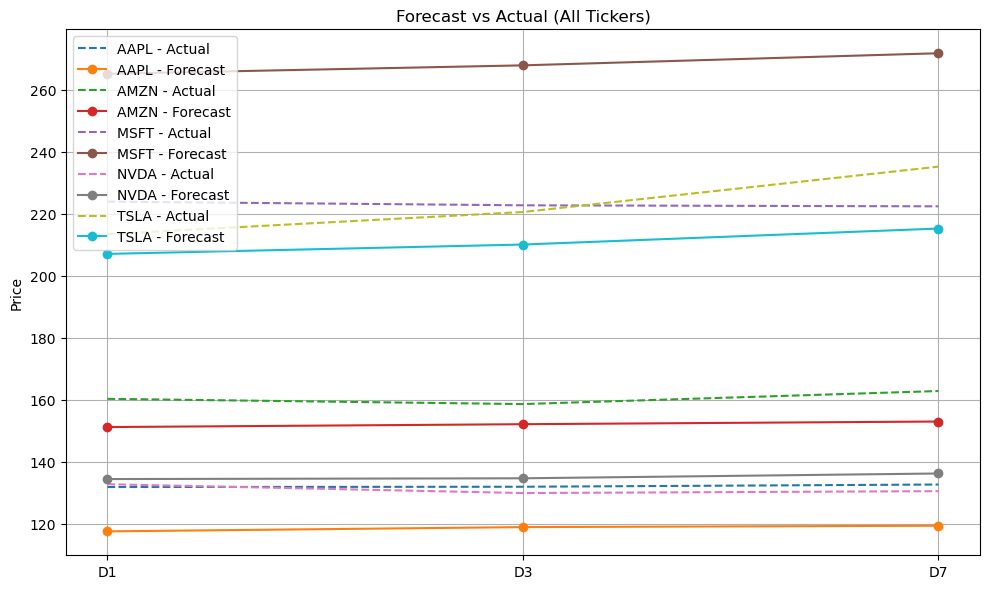

In [53]:
plt.figure(figsize=(10, 6))
for i, row in results_df.iterrows():
    plt.plot(['D1', 'D3', 'D7'], [row['Actual Day 1'], row['Actual Day 3'], row['Actual Day 7']], 
             label=f"{row['Ticker']} - Actual", linestyle='--')
    plt.plot(['D1', 'D3', 'D7'], [row['Day 1 Forecast'], row['Day 3 Forecast'], row['Day 7 Forecast']], 
             label=f"{row['Ticker']} - Forecast", marker='o')
plt.title('Forecast vs Actual (All Tickers)')
plt.ylabel('Price')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()